In [0]:
#Mengimport library
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
#Menghubungkan google colab dengan drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Hyperparameter
EPOCHS = 100
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
directory_root = '/content/drive/My Drive/Deep Learning/'
width=224
height=224
depth=3

In [0]:
#mengkonversi gambar ke array
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [0]:
#List gambar dan label
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Moldy_Cocoa ...
[INFO] Processing Whole_Beans_Cocoa ...
[INFO] Processing Fermented_Cocoa ...
[INFO] Processing Bean_Fraction_Cocoa ...
[INFO] Processing Broken_Beans_Cocoa ...
[INFO] Processing Unfermented_Cocoa ...
[INFO] Image loading completed


In [0]:
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [0]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [0]:
#Spliting data ke train, test
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42)

In [0]:
#konfigurasi augmentasi
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [0]:
# Mendefinisikan model Inception

#mengimport library
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import concatenate

# Inisialisasi Core
kernel_init = tf.keras.initializers.glorot_uniform()

# Inisialisasi offset
bias_init = tf.keras.initializers.Constant(value=0.2)


# Fungsi yang menghasilkan Modul Inception
def inception_module(x,
                     filters_1x1,
                     filters_3x3_reduce,
                     filters_3x3,
                     filters_5x5_reduce,
                     filters_5x5,
                     filters_pool_proj,
                     name=None):

    # Konvolusi 1 × 1
    conv_1x1 = Conv2D(filters_1x1,
                      (1, 1),
                      padding='same',
                      activation='relu')(x)
    conv_1x1 = BatchNormalization()(conv_1x1)

    # Konvolusi 1 × 1 untuk reduksi dimensi Konvolusi 3x3
    conv_3x3 = Conv2D(filters_3x3_reduce,
                      (1, 1),
                      padding='same',
                      activation='relu')(x)
    conv_3x3 = BatchNormalization()(conv_3x3)

    # Konvolusi 3x3
    conv_3x3 = Conv2D(filters_3x3,
                      (3, 3),
                      padding='same',
                      activation='relu')(conv_3x3)
    conv_3x3 = BatchNormalization()(conv_3x3)

    # Konvolusi 1 × 1 untuk reduksi dimensi Konvolusi 5x5
    conv_5x5 = Conv2D(filters_5x5_reduce,
                      (1, 1),
                      padding='same',
                      activation='relu')(x)
    conv_5x5 = BatchNormalization()(conv_5x5)

    # Konvolusi 5x5
    conv_5x5 = Conv2D(filters_5x5, (5, 5),
                      padding='same',
                      activation='relu')(conv_5x5)
    conv_5x5 = BatchNormalization()(conv_5x5)

    # Max pooling
    pool_proj = MaxPool2D((3, 3), strides=(1, 1), padding='same')(x)

    # Konvolusi 1 × 1 untuk dimensi maksimum yang dikurangi
    pool_proj = Conv2D(filters_pool_proj,
                       (1, 1),
                       padding='same',
                       activation='relu')(pool_proj)
    pool_proj = BatchNormalization()(pool_proj)

    # Stack merge
    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=3, name=name)

    return output

In [0]:
#mengimport library
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


# Mendefinisikan GoogleNet / Inception-V1
class GoogleNet:
    @staticmethod
    def build(width, height, channel, classes):

        input_layer = Input(shape=(width, height, channel))

        # Inisialisasi inti
        kernel_init = tf.keras.initializers.glorot_uniform()

        # Inisialisasi offset
        bias_init = tf.keras.initializers.Constant(value=0.2)

        # Konvolusi
        x = Conv2D(64,
                   (7, 7),
                   padding='same',
                   strides=(2, 2),
                   activation='relu',
                   name='conv_1_7x7/2')(input_layer)
        x = BatchNormalization()(x)

        # Max pooling
        x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_1_3x3/2')(x)

        # Konvolusi
        x = Conv2D(64,
                   (1, 1),
                   padding='same',
                   strides=(1, 1),
                   activation='relu',
                   name='conv_2a_3x3/1')(x)
        x = BatchNormalization()(x)

        # Konvolusi
        x = Conv2D(192,
                   (3, 3),
                   padding='same',
                   strides=(1, 1),
                   activation='relu',
                   name='conv_2b_3x3/1')(x)
        x = BatchNormalization()(x)

        # Max pooling
        x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_2_3x3/2')(x)

        # Inception Module
        x = inception_module(x,
                             filters_1x1=64,
                             filters_3x3_reduce=96,
                             filters_3x3=128,
                             filters_5x5_reduce=16,
                             filters_5x5=32,
                             filters_pool_proj=32,
                             name='inception_3a')

        # Inception Module
        x = inception_module(x,
                             filters_1x1=128,
                             filters_3x3_reduce=128,
                             filters_3x3=192,
                             filters_5x5_reduce=32,
                             filters_5x5=96,
                             filters_pool_proj=64,
                             name='inception_3b')

        # Max pooling
        x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_3_3x3/2')(x)

        # Inception Module
        x = inception_module(x,
                             filters_1x1=192,
                             filters_3x3_reduce=96,
                             filters_3x3=208,
                             filters_5x5_reduce=16,
                             filters_5x5=48,
                             filters_pool_proj=64,
                             name='inception_4a')

        # Inception Module
        x = inception_module(x,
                             filters_1x1=160,
                             filters_3x3_reduce=112,
                             filters_3x3=224,
                             filters_5x5_reduce=24,
                             filters_5x5=64,
                             filters_pool_proj=64,
                             name='inception_4b')

        # Inception Module
        x = inception_module(x,
                             filters_1x1=128,
                             filters_3x3_reduce=128,
                             filters_3x3=256,
                             filters_5x5_reduce=24,
                             filters_5x5=64,
                             filters_pool_proj=64,
                             name='inception_4c')

        # Inception Module
        x = inception_module(x,
                             filters_1x1=112,
                             filters_3x3_reduce=144,
                             filters_3x3=288,
                             filters_5x5_reduce=32,
                             filters_5x5=64,
                             filters_pool_proj=64,
                             name='inception_4d')

        # Inception Module
        x = inception_module(x,
                             filters_1x1=256,
                             filters_3x3_reduce=160,
                             filters_3x3=320,
                             filters_5x5_reduce=32,
                             filters_5x5=128,
                             filters_pool_proj=128,
                             name='inception_4e')

        # Max pooling
        x = MaxPool2D((3, 3), padding='same', strides=(2, 2), name='max_pool_4_3x3/2')(x)

        # Inception Module
        x = inception_module(x,
                             filters_1x1=256,
                             filters_3x3_reduce=160,
                             filters_3x3=320,
                             filters_5x5_reduce=32,
                             filters_5x5=128,
                             filters_pool_proj=128,
                             name='inception_5a')

        # Inception Module
        x = inception_module(x,
                             filters_1x1=384,
                             filters_3x3_reduce=192,
                             filters_3x3=384,
                             filters_5x5_reduce=48,
                             filters_5x5=128,
                             filters_pool_proj=128,
                             name='inception_5b')

        # Global Avarage Pooling
        x = GlobalAveragePooling2D(name='avg_pool_5_3x3/1')(x)

        # Random inactivation
        x = Dropout(0.40)(x)

        # Full connection/output
        x = Dense(classes, activation='softmax', name='output')(x)

        # Create GoogleNet model
        # return Model(input_layer, [x, x1, x2], name='inception_v1')
        return Model(input_layer, x, name='inception_v1')


# Test GoogleNet class instantiation and output summary information of GoogleNet model
if __name__ == "__main__":
    model = GoogleNet.build(width=224, height=224, channel=3, classes=6)
    print(model.summary())

Model: "inception_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv_1_7x7/2 (Conv2D)           (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 112, 112, 64) 256         conv_1_7x7/2[0][0]               
__________________________________________________________________________________________________
max_pool_1_3x3/2 (MaxPooling2D) (None, 56, 56, 64)   0           batch_normalization_57[0][0]     
_______________________________________________________________________________________

In [0]:
from tensorflow.keras.optimizers import SGD, Adam, Adamax
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

In [0]:
model.compile(loss="binary_crossentropy", optimizer='Adam',metrics=["accuracy"])

In [0]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS,
    validation_data=(x_test, y_test),
    validation_steps=1200// BS,
    max_queue_size=BS*2,
    verbose=1
    )

Epoch 1/100
15/15 [==============================] - 17s 1s/step - loss: 0.4796 - acc: 0.8333 - val_loss: 0.4605 - val_acc: 0.8333
Epoch 2/100
15/15 [==============================] - 6s 407ms/step - loss: 0.3887 - acc: 0.8486 - val_loss: 0.5578 - val_acc: 0.8333
Epoch 3/100
15/15 [==============================] - 5s 367ms/step - loss: 0.3040 - acc: 0.8680 - val_loss: 0.5673 - val_acc: 0.8333
Epoch 4/100
15/15 [==============================] - 6s 382ms/step - loss: 0.2593 - acc: 0.8762 - val_loss: 1.2667 - val_acc: 0.7127
Epoch 5/100
15/15 [==============================] - 6s 381ms/step - loss: 0.2454 - acc: 0.8940 - val_loss: 1.6319 - val_acc: 0.7127
Epoch 6/100
15/15 [==============================] - 6s 383ms/step - loss: 0.2245 - acc: 0.9001 - val_loss: 0.9149 - val_acc: 0.7127
Epoch 7/100
15/15 [==============================] - 6s 372ms/step - loss: 0.1815 - acc: 0.9194 - val_loss: 0.7106 - val_acc: 0.8008
Epoch 8/100
15/15 [==============================] - 6s 397ms/step - lo

In [0]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
123/123 [==============================] - 0s 3ms/sample - loss: 0.5833 - acc: 0.8713
Test Accuracy: 87.12737560272217


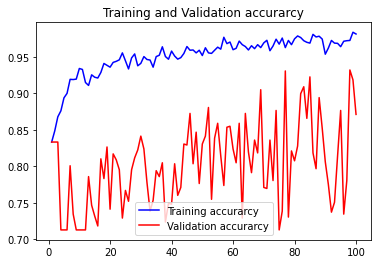

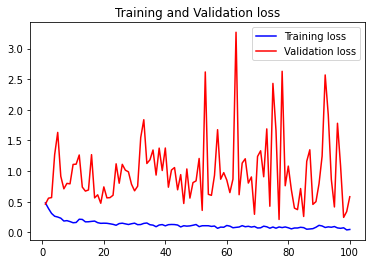

In [0]:
#visualisasi akurasi
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()